# **Project 3: Linear Classification**
By Daniel Kim and Philip Blumin

imports

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd

# **Preprocessing**

In this section two classes are generated with a mulivaraite normal distribution with different mu values. A column of 1s is append to on the left and the dataset is shuffled. The end dataset has 2000 rows and 2 features.

In [ ]:
mu1 = [1, 1]
mu2 = [-1, -1]
N = 1000
sigma = np.eye(2)
class0 = np.random.multivariate_normal(mu1,sigma,N)
class1 = np.random.multivariate_normal(mu2,sigma,N)

dataset = np.empty((0,4), float)

for i in range(0,N):
  dataset = np.vstack( (dataset, np.array( [1, class0[i][0] , class0[i][1] , 0] ) ) )
  dataset = np.vstack( (dataset, np.array( [1, class1[i][0] , class1[i][1] , 1] ) ) )


np.random.shuffle(dataset)


Dataset is split

In [ ]:
trainData, testData = train_test_split(dataset, test_size=0.2)

In [ ]:
trainData

array([[ 1.        , -0.73895187, -2.81575373,  1.        ],
       [ 1.        , -0.57521638,  1.85906872,  0.        ],
       [ 1.        ,  0.03201094,  0.13086222,  1.        ],
       ...,
       [ 1.        ,  1.92947885, -0.48959812,  0.        ],
       [ 1.        , -1.13316   , -1.05270702,  1.        ],
       [ 1.        , -2.28275097, -2.19539364,  1.        ]])

Function to plot ROC

In [ ]:
def plotROC(predictions):
  predictions = np.array(predictions)
  fpr, tpr,thresholds = metrics.roc_curve(np.array(testData[:,-1].astype(float)), np.array(predictions.flatten()))
  plt.figure(figsize=(6,6))
  plt.plot(fpr, tpr, marker='.')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title("ROC Curve")
  plt.show()

# **Gaussian generative model**

In this function the gaussian model is trained and with the inputed testData predictions are determined. The prints out the percent correct and outputs the probability of choosing class0 for each row

In [ ]:
def GaussianModel(trainData,testData, numOfFeatures):
  train_X = trainData[:,1:numOfFeatures+1]
  train_y = trainData[:,-1]
  test_X = testData[:,1:numOfFeatures+1]
  test_y = testData[:,-1]
  class0_train = train_X[train_y == 0,:].astype(float)
  class1_train = train_X[train_y == 1,:].astype(float)
  mu0 = np.mean(class0_train, axis=0)
  mu1 = np.mean(class1_train, axis=0)
  X_Cov0 = np.cov(class0_train.T)
  X_Cov1 = np.cov(class1_train.T)
  X_Cov0.shape
  logLikly0 = np.log10(multivariate_normal.pdf(test_X,mu0,X_Cov0))
  logLikly1 = np.log10(multivariate_normal.pdf(test_X,mu1,X_Cov1))
  prob = logLikly0/(logLikly0 + logLikly1)
  logLikly = [logLikly0,logLikly1]
  logLikly = np.asarray(logLikly)

  [M,pred] = logLikly.max(axis=0), logLikly.argmax(axis=0)

  eval = test_y - pred;
  eval[eval != 0] = 1;
  error = np.sum(eval)/len(test_y);
  correct = (1 - error) * 100;
  print("Percent correct: " + str(correct) + "%")

  return prob

In [ ]:
numOfFeatures = 2
pred = GaussianModel(trainData,testData, numOfFeatures)


Percent correct: 92.5%


wow 92.5% correct looks good!

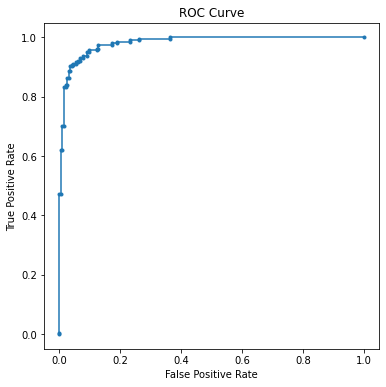

In [ ]:
plotROC(pred)

# **Logistic regression classifier**

sigmoid function

In [ ]:
def sigmoid(a):
  return 1/(1 + np.exp(-a)) #eq. 4.59

The function below is the implimented IRLS algorithm based off the equations in the textbook. This outputs the weights

In [ ]:
#IRLS alg pg 207
def IRLS_train(traindata, numOfFeatures):
  iteration = 50
  w = np.asmatrix(np.ones(numOfFeatures+1)*0.1).T
  phi = np.empty((0,numOfFeatures+1), float)
  N = len(trainData)
  t = np.asmatrix(trainData[:,-1]).T
  for i in range(0,N):
  
    phi = np.vstack( (phi, np.array(trainData[i][0:numOfFeatures+1].astype(float))) )
    #phi1 = np.asmatrix([1, trainData[i][1] ,trainData[i][2] ])

  phi = np.asmatrix(phi)

  for i in range(0,10):
    y = sigmoid(w.T.astype(float) @ phi.T.astype(float)).T #eq. 4.87
    R = np.multiply(np.eye(N), np.multiply(y, (np.ones((N,1))-y))) #eq. 4.98
    z = phi @ w - (np.linalg.inv(R) @ (y - t)) #eq. 4.100
    w = np.linalg.inv(phi.T @ R @ phi) @ phi.T @ R @ z #eq. 4.99
    # if i % 50 == 0:
    #   print(i)
  return w

This functions takes in the trained weights and outputs the probability of each row as well as printing the percent correct

In [ ]:
def IRLS_test(testData, numOfFeatures, w):
  test_phi = np.empty((0,numOfFeatures+1), float)
  N = len(testData)
  for i in range(0, N):
    test_phi = np.vstack( (test_phi, np.array(testData[i][0:numOfFeatures+1])) )
  test_phi = np.asmatrix(test_phi)

  predictions = sigmoid(test_phi @ w)
  probs = sigmoid(test_phi @ w)
  predictions[predictions < .5] = 0
  predictions[predictions > .5] = 1
  test_t = np.asmatrix(testData[:,-1]).T

  eval = predictions - test_t
  eval = np.abs(eval)
  error = np.sum(eval)/len(eval);
  correct = (1 - error) * 100;
  print("Percent correct: " + str(correct) + "%")
  return probs

In [ ]:
def plotROC(predictions):
  predictions = np.array(predictions)
  fpr, tpr,thresholds = metrics.roc_curve(np.array(testData[:,-1]), np.array(predictions.flatten()))
  plt.figure(figsize=(6,6))
  plt.plot(fpr, tpr, marker='.')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title("ROC Curve")
  plt.show()

In [ ]:
numOfFeatures = 2
w = IRLS_train(trainData, numOfFeatures)
predictions = IRLS_test(testData, numOfFeatures, w)

Percent correct: 92.5%


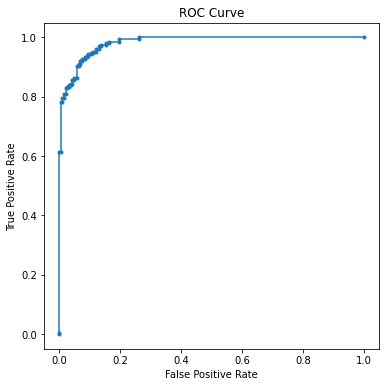

In [ ]:
plotROC(predictions)

In [ ]:
x = np.linspace(np.min(dataset[:,1]), np.max(dataset[:,1]),len(dataset))
y = (np.array(w[1])[0][0] * x) + np.array(w[2])[0][0]

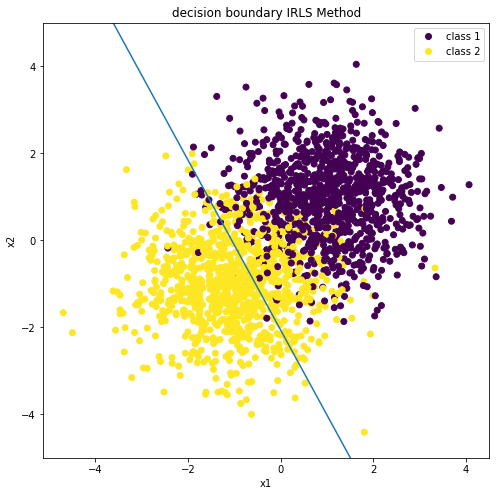

In [ ]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(dataset[:,1],dataset[:,2],c=dataset[:,3])
plt.legend(handles=scatter.legend_elements()[0], labels=['class 1','class 2'])
plt.plot(x,y)
plt.title("decision boundary IRLS Method")
plt.xlabel('x1')
plt.ylabel('x2')
plt.ylim([-5,5])
plt.show()

# **Citrus Dataset**

https://www.kaggle.com/joshmcadams/oranges-vs-grapefruit?select=citrus.csv

This dataset has 5 features and categorizes oranges vs grapefruits

In [ ]:
import pandas as pd

In [ ]:
citrusData = pd.read_csv('citrus.csv') 
citrusData.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


Before using the previous functions created a column of 1s is created for the bais and the classes are changed to 0 and 1 rather than words

In [ ]:
citrusData['name'][citrusData['name'] == 'orange'] = 0
citrusData['name'][citrusData['name'] == 'grapefruit'] = 1
citrusData['ones'] = pd.Series(np.ones(len(citrusData)), index=citrusData.index)
citrusData

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,diameter,weight,red,green,blue,ones
0,0,2.96,86.76,172,85,2,1.0
1,0,3.91,88.05,166,78,3,1.0
2,0,4.42,95.17,156,81,2,1.0
3,0,4.47,95.60,163,81,4,1.0
4,0,4.48,95.76,161,72,9,1.0
...,...,...,...,...,...,...,...
9995,1,15.35,253.89,149,77,20,1.0
9996,1,15.41,254.67,148,68,7,1.0
9997,1,15.59,256.50,168,82,20,1.0
9998,1,15.92,260.14,142,72,11,1.0


In [ ]:
citrusData['ones'] = pd.Series(np.ones(len(citrusData)), index=citrusData.index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
citrusData = citrusData[['ones','diameter', 'weight', 'red', 'green', 'blue','name']]
citrusData

,ones,diameter,weight,red,green,blue,name
0,1.0,2.96,86.76,172,85,2,0
1,1.0,3.91,88.05,166,78,3,0
2,1.0,4.42,95.17,156,81,2,0
3,1.0,4.47,95.60,163,81,4,0
4,1.0,4.48,95.76,161,72,9,0
...,...,...,...,...,...,...,...
9995,1.0,15.35,253.89,149,77,20,1
9996,1.0,15.41,254.67,148,68,7,1
9997,1.0,15.59,256.50,168,82,20,1
9998,1.0,15.92,260.14,142,72,11,1


In [ ]:
trainData, testData = train_test_split(citrusData, test_size=0.2)
trainData = np.array(trainData)
testData = np.array(testData)

**Gaussian generative model**

In [ ]:
numOfFeatures = 5
pred = GaussianModel(trainData,testData, numOfFeatures)


Percent correct: 97.0%


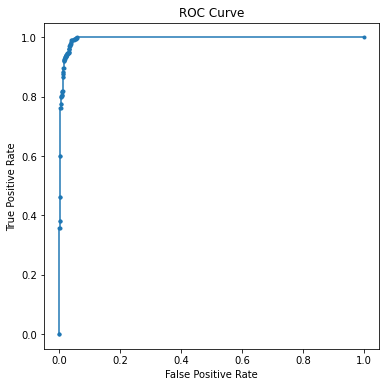

In [ ]:
plotROC(pred)

**Logistic regression classifier**

In [ ]:
iteration = 50
w = np.asmatrix(np.ones(numOfFeatures+1)*0.001).T
phi = np.empty((0,numOfFeatures+1), float)
N = len(trainData)
t = np.asmatrix(trainData[:,-1]).T
for i in range(0,N):

  phi = np.vstack( (phi, np.array(trainData[i][0:numOfFeatures+1].astype(float))) )
  #phi1 = np.asmatrix([1, trainData[i][1] ,trainData[i][2] ])

phi = np.asmatrix(phi)

for i in range(0,10):
  y = sigmoid(w.T.astype(float) @ phi.T.astype(float)).T
  R = np.multiply(np.eye(N), np.multiply(y, (np.ones((N,1))-y)))
  z = phi @ w - (np.linalg.inv(R) @ (y - t))
  w = np.linalg.inv(phi.T @ R @ phi) @ phi.T @ R @ z
  print(i)

0
1
2
3
4
5
6
7
8
9


In [ ]:
test_phi = np.empty((0,numOfFeatures+1), float)
N = len(testData)
for i in range(0, N):
  test_phi = np.vstack( (test_phi, np.array(testData[i][0:numOfFeatures+1]).astype(float)) )
test_phi = np.asmatrix(test_phi)

predictions = sigmoid(test_phi.astype(float) @ w)
probs = sigmoid(test_phi @ w)
predictions[predictions < .5] = 0
predictions[predictions > .5] = 1
test_t = np.asmatrix(testData[:,-1]).T

eval = predictions - test_t
eval = np.abs(eval)
error = np.sum(eval)/len(eval);
correct = (1 - error) * 100;
print("Percent correct: " + str(correct) + "%")

Percent correct: 96.75%
